In [21]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
pd.set_option('display.max_colwidth', None)
from scipy.optimize import minimize
from scipy.optimize import fsolve
from scipy.integrate import quad
import scipy.integrate as integrate
import scipy.special as special
import math
import random
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import quantecon as qe
from mpl_toolkits.mplot3d import Axes3D
from math import sqrt
from pylab import plot, show, grid, xlabel, ylabel
import copy

In [22]:
import pickle

def save_in_pickle(save_object, save_file):
    with open(save_file, "wb") as pickle_out:
        pickle.dump(save_object, pickle_out)

def load_from_pickle(pickle_file):
    with open(pickle_file, "rb") as pickle_in:
        return pickle.load(pickle_in)

# Data Generation

In [23]:
# The statespace
states = ["Mild","Moderate","Harsh"]

# Probabilities matrix (transition matrix)
transition_matrix = [[0  ,0.7,0.3],
                     [0.6,0  ,0.4],
                     [0.3,0.7,0  ]]

experiment_time = 20000
# State exponential distribution
state_lambdas = [2000,5000,3000]
start_p = [0.3,.5,.2]


no_runs = 300

In [24]:
def generate_path_CTMC(transition_matrix, state_lambdas, start_p, experiment_time, output_length=1):
    """
    Generates output_length number of paths (with state and times) based on the parameters for the CTMC
    """
    n = len(state_lambdas)
    paths = []
    for i in range(output_length):
        curr_time = 0
        curr_state = np.random.choice(np.arange(n), p=start_p)

        path = []
        while curr_time < experiment_time:
            curr_time = min(curr_time + np.random.exponential(state_lambdas[curr_state]),experiment_time)
            path.append((curr_state,int(round(curr_time,0))))
            curr_state = np.random.choice(np.arange(n), p=transition_matrix[curr_state])
        paths.append(path)
    return paths

In [26]:
paths = generate_path_CTMC(transition_matrix, state_lambdas, start_p, experiment_time, no_runs)

In [27]:
def brownian(x0, n, dt, delta, net_increase, out=None):
    """
    Generate an instance of Brownian motion (i.e. the Wiener process):

        X(t) = X(0) + N(0, delta**2 * t; 0, t)

    where N(a,b; t0, t1) is a normally distributed random variable with mean a and
    variance b.  The parameters t0 and t1 make explicit the statistical
    independence of N on different time intervals; that is, if [t0, t1) and
    [t2, t3) are disjoint intervals, then N(a, b; t0, t1) and N(a, b; t2, t3)
    are independent.
    
    Written as an iteration scheme,

        X(t + dt) = X(t) + N(0, delta**2 * dt; t, t+dt)


    If `x0` is an array (or array-like), each value in `x0` is treated as
    an initial condition, and the value returned is a numpy array with one
    more dimension than `x0`.

    Arguments
    ---------
    x0 : float or numpy array (or something that can be converted to a numpy array
         using numpy.asarray(x0)).
        The initial condition(s) (i.e. position(s)) of the Brownian motion.
    n : int
        The number of steps to take.
    dt : float
        The time step.
    delta : float
        delta determines the "speed" of the Brownian motion.  The random variable
        of the position at time t, X(t), has a normal distribution whose mean is
        the position at time t=0 and whose variance is delta**2*t.
    out : numpy array or None
        If `out` is not None, it specifies the array in which to put the
        result.  If `out` is None, a new numpy array is created and returned.

    Returns
    -------
    A numpy array of floats with shape `x0.shape + (n,)`.
    
    Note that the initial value `x0` is not included in the returned array.
    """

    x0 = np.asarray(x0)

    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    r = norm.rvs(size=x0.shape + (n,), scale=delta*sqrt(dt))

    # If `out` was not given, create an output array.
    if out is None:
        out = np.empty(r.shape)

    # This computes the Brownian motion by forming the cumulative sum of
    # the random samples. 
    np.cumsum(r, axis=-1, out=out)

#     out = out + 1000
    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)
    out += np.repeat(np.arange(n).reshape(1,-1),len(x0),axis=0)*net_increase/n

    return np.concatenate((x0.reshape((-1,1)),out),axis=1)

In [28]:
N = 20000
T = 20000.0
# # Time step size
dt = T/N
# The Wiener process parameter.
delta = .25
net_increases = [160.0,400.0,1000.0]
x_0 = 50
mus = [i/T for i in net_increases]
D2 = 150

In [29]:
mus

[0.008, 0.02, 0.05]

In [30]:
X_t = []
for i in range(no_runs):
    start = 0
    x = np.empty((N+1))
    x[0] = x_0
    for env, end in paths[i]:
        new_path = brownian([x[start]], N, dt, delta, net_increases[env])
        x[start:end+1] = new_path[0][:end-start+1]
        start = end
    X_t.append(x)

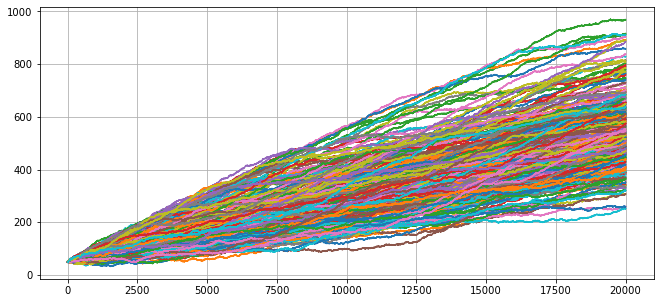

In [31]:
for k in range(no_runs):
    plot(X_t[k])
grid(True)

In [32]:
clipped_paths = []
clipped_X_t = []
for i in range(no_runs):
    limit = np.argmax(X_t[i]>D2)
    new_path = []
    for env,time in paths[i]:
        if time < limit:
            new_path.append((env,time))
        else:
            new_path.append((env,limit))
            break
    clipped_X_t.append(X_t[i][:limit+1])
    clipped_paths.append(new_path)

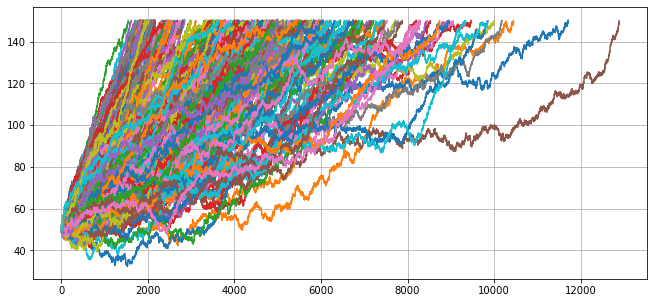

In [33]:
for k in range(no_runs):
    plot(clipped_X_t[k])
grid(True)

In [158]:
# save_in_pickle(clipped_paths,'clipped_paths.pkl')
# save_in_pickle(clipped_X_t,'clipped_X_t.pkl')

In [34]:
clipped_paths = load_from_pickle('clipped_paths.pkl')
clipped_X_t = load_from_pickle('clipped_X_t.pkl')

# Split into test and validation

In [35]:
train_paths, test_paths = clipped_paths[:150], clipped_paths[150:]
train_X, test_X = clipped_X_t[:150], clipped_X_t[150:]

# Parameter Estimation

In [36]:
phi = np.mean([X[0] for X in train_X])
phi

50.0

In [37]:
X_t_env = [[],[],[]]
for i in range(len(train_paths)):
    start = 0
    for env,end in train_paths[i]:
        diff = train_X[i][start] - phi
        X_t_env[env].append(np.array(train_X[i][start:end+1]) - diff)
        start = end+1

In [38]:
# colors = ['tab:blue','tab:orange','tab:green']
# for i in range(3)[::-1]:
#     for k in range(len(X_t_env[i])):
#         fig = plot(X_t_env[i][k],color=colors[i], alpha=0.5)
#     grid(True)
mus_env = []
sds_env = []
for i in range(3):
    mus = []
    for k in range(len(X_t_env[i])):
        y = np.array(X_t_env[i][k]).reshape((-1,1))
        X = np.arange(len(y)).reshape((-1,1))
        reg = LinearRegression().fit(X, y)
        mus.append(reg.coef_[0][0])
    mus_env.append(np.mean(mus))
    sds_env.append(np.std(mus))
mus_env

[0.008887302342945224, 0.018737783614459193, 0.04853615534519896]

In [39]:
p = np.bincount([path[0][0] for path in train_paths])/len(train_paths)
p

array([0.25333333, 0.61333333, 0.13333333])

In [40]:
trans_count = np.zeros((3,3),dtype=int)
for i in range(100):
    for j in range(len(train_paths[i])-1):
        trans_count[train_paths[i][j][0],train_paths[i][j+1][0]] += 1
trans_matrix = trans_count/trans_count.sum(axis=1).reshape((-1,1))
trans_matrix

array([[0.        , 0.6984127 , 0.3015873 ],
       [0.70909091, 0.        , 0.29090909],
       [0.46666667, 0.53333333, 0.        ]])

In [41]:
failure_times = [[],[],[]]
censored_failure_times = [[],[],[]]
for i in range(len(train_paths)):
    start = 0
    for env,end in train_paths[i][:-1]:
        failure_times[env].append(end-start)
        start = end
    env, end = train_paths[i][-1]
    censored_failure_times[env].append(end-start)
lambdas = []
for i in range(3):
    r = len(failure_times[i])
    lambdas.append(1/(r/(np.sum(failure_times[i])+np.sum(censored_failure_times[i]))))
lambdas

[2249.8314606741574, 5630.9885057471265, 2411.5806451612902]

In [42]:
norm_X_t_env =  copy.deepcopy(X_t_env)
for env in range(3):
    for i in range(len(norm_X_t_env[env])):
        for j in range(len(norm_X_t_env[env][i])):
            norm_X_t_env[env][i][j] -= mus_env[env]*j
colors = ['tab:blue','tab:orange','tab:green']
norm_diff = []
for env in range(3):
    for i in range(len(norm_X_t_env[env])):
        for j in range(len(norm_X_t_env[env][i])-1):
            norm_diff.append(norm_X_t_env[env][i][j+1]-norm_X_t_env[env][i][j])
temp, var = norm.fit(norm_diff) # expecting 0, 0.25
temp,var

(0.0005746710102066798, 0.2500516323936371)

# RUL estimation

Test data will be clipped at a threshold of 100 (start value is 50, failure threshold is 150)

In [43]:
D3 = 100
clipped_test_paths = []
clipped_test_X = []
for i in range(len(test_X)):
    limit = np.argmax(test_X[i]>D3)
    new_path = []
    for env,time in test_paths[i]:
        if time < limit:
            new_path.append((env,time))
        else:
            new_path.append((env,limit))
            break
    clipped_test_X.append(test_X[i][:limit+1])
    clipped_test_paths.append(new_path)

In [44]:
true_failure_times = [len(i) for i in test_X]
true_failure_times[0]

5288

In [78]:
def find_failure_time(tm, state_lambdas, start_state, start_time, start_x, 
                      delta, drifts, D2, dt=1, no_iters = 100):
    failure_times = []
    p = []
    for j in range(no_iters):
        path = [start_x]
        curr_state = start_state
        while all(i < D2 for i in path):
            sojourn_time = int(round(np.random.exponential(state_lambdas[curr_state]),0))
#             print(sojourn_time,curr_state, drifts[curr_state]*sojourn_time)
            new_path = brownian([path[-1]], sojourn_time, dt, delta, drifts[curr_state]*sojourn_time)[0]
            path = np.concatenate((path, new_path[1:]))
            curr_state = np.random.choice(np.arange(3), p=tm[curr_state])
        limit = np.argmax(path>D2)
#         print(limit,start_time)
        failure_times.append(limit+start_time)
        p.append(path)
    failure_times = np.array(failure_times)
    return np.mean(failure_times),np.std(failure_times), p

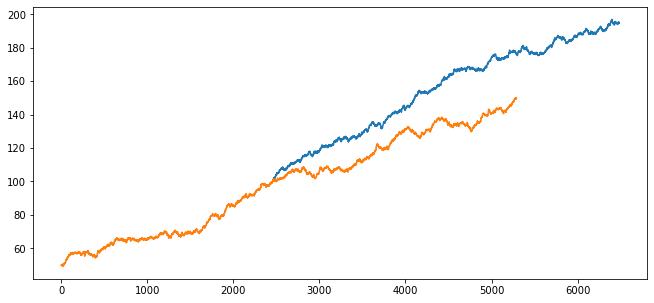

In [99]:
x = 0
e,s,p = find_failure_time(trans_matrix, lambdas, clipped_test_paths[x][-1][0], 
                  len(clipped_test_X[x]), clipped_test_X[x][-1], 
                      var, mus_env, D2, dt=1, no_iters = 1)
plot(np.arange(len(clipped_test_X[x]),len(clipped_test_X[x])+len(p[0])),p[0])
plot(test_X[0])

In [85]:
results = []
for i in range(len(test_paths)):
    exp, std, _ = find_failure_time(trans_matrix, lambdas, clipped_test_paths[i][-1][0], 
                  len(clipped_test_X[i]), clipped_test_X[i][-1], 
                      var, mus_env, D2, dt=1, no_iters = 500)
    no_std = abs(true_failure_times[i]-exp)/std
    results.append((exp,std,no_std))
    print(f'Actual: {true_failure_times[i]}, Pred: {exp}, S.D.:{std}, # of S.Ds.:{no_std}')

Actual: 5288, Pred: 5314.66, S.D.:1022.4374251757415, # of S.Ds.:0.02607494536442404
Actual: 6860, Pred: 7351.272, S.D.:1416.6237898665968, # of S.Ds.:0.3467907312542471
Actual: 3462, Pred: 3901.762, S.D.:943.4657584438345, # of S.Ds.:0.46611336560359085
Actual: 2758, Pred: 2928.232, S.D.:880.3379227183161, # of S.Ds.:0.19337119940755923
Actual: 4373, Pred: 5235.79, S.D.:985.9141797844272, # of S.Ds.:0.8751167370253781
Actual: 4448, Pred: 5222.208, S.D.:907.4950384084754, # of S.Ds.:0.8531264273992851
Actual: 2127, Pred: 2200.488, S.D.:865.2494587435464, # of S.Ds.:0.08493273154624548
Actual: 2543, Pred: 3172.776, S.D.:844.297344437373, # of S.Ds.:0.7459173052589346
Actual: 7094, Pred: 7776.666, S.D.:899.1234945456603, # of S.Ds.:0.7592572145442167
Actual: 1875, Pred: 2316.618, S.D.:833.9790741235657, # of S.Ds.:0.5295312720695052
Actual: 4281, Pred: 4063.522, S.D.:895.6206571512294, # of S.Ds.:0.24282378735183413
Actual: 6680, Pred: 6885.464, S.D.:951.7959217731499, # of S.Ds.:0.21586

Actual: 5629, Pred: 5836.956, S.D.:1371.3479420132587, # of S.Ds.:0.1516434988006782
Actual: 4286, Pred: 4900.692, S.D.:984.2206404744823, # of S.Ds.:0.6245469508784773
Actual: 5852, Pred: 5564.228, S.D.:1044.1367247712344, # of S.Ds.:0.2756075839235034
Actual: 3236, Pred: 2850.688, S.D.:916.9582251422363, # of S.Ds.:0.42020671109660557
Actual: 5424, Pred: 5845.35, S.D.:915.699893797089, # of S.Ds.:0.460139837139009
Actual: 4132, Pred: 4488.336, S.D.:889.3480416035108, # of S.Ds.:0.4006710346576127
Actual: 3227, Pred: 3679.22, S.D.:1065.7756778984965, # of S.Ds.:0.4243106775449128
Actual: 4918, Pred: 6364.642, S.D.:1629.5275959111586, # of S.Ds.:0.8877677209210456
Actual: 4928, Pred: 6097.824, S.D.:968.9739341303252, # of S.Ds.:1.2072811855872487
Actual: 1691, Pred: 2377.476, S.D.:1083.60298884047, # of S.Ds.:0.6335124645000996
Actual: 2774, Pred: 3212.276, S.D.:886.0951753756477, # of S.Ds.:0.49461503930906614
Actual: 4429, Pred: 5015.328, S.D.:778.6152171746966, # of S.Ds.:0.75303948

In [100]:
save_in_pickle(results,'results.pkl')
save_in_pickle(true_failure_times,'true_failure_times.pkl')

In [101]:
results = load_from_pickle('results.pkl')
true_failure_times = load_from_pickle('true_failure_times.pkl')

In [103]:
df = pd.concat((pd.DataFrame(data=true_failure_times,columns=['True Failure Times']),
          pd.DataFrame(data=results,columns=['Expected Failure Time','S.D.','Deviation in # of S.D.'])),
         axis=1)
df.head()

,True Failure Times,Expected Failure Time,S.D.,Deviation in # of S.D.
0,5288,5314.660,1022.437425,0.026075
1,6860,7351.272,1416.623790,0.346791
2,3462,3901.762,943.465758,0.466113
3,2758,2928.232,880.337923,0.193371
4,4373,5235.790,985.914180,0.875117


In [104]:
df.iloc[:,2].describe()

count     150.000000
mean      982.265903
std       171.445151
min       737.358232
25%       886.908392
50%       943.421222
75%      1009.807135
max      1629.527596
Name: S.D., dtype: float64

In [105]:
df.iloc[:,3].describe()

count    150.000000
mean       0.660620
std        0.439446
min        0.006983
25%        0.362181
50%        0.568383
75%        0.869619
max        2.333531
Name: Deviation in # of S.D., dtype: float64

In [106]:
(df.iloc[:,0]-df.iloc[:,1]).describe()

count     150.000000
mean     -220.155707
std       776.691378
min     -2609.074000
25%      -634.167000
50%      -408.829000
75%       215.865500
max      2391.686000
dtype: float64

In [107]:
(df.iloc[:,0]-df.iloc[:,1]).apply(abs).describe()

count     150.000000
mean      653.123093
std       471.816346
min         6.732000
25%       360.768500
50%       535.145000
75%       831.042500
max      2609.074000
dtype: float64